# **IE 630 Assignment 2**
## Simulating the Inventory Model with (M, L) policy    
Name: Subhadeep Chaudhuri | Roll: 19i190010 <br>
Name: Abhishek Narayan Chaudhury | Roll: 19i190005 

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
from tqdm import tqdm 
sns.set_style('whitegrid')

In [2]:
#######################################################################
## Function to get the cost of y units that are placed in each order
#######################################################################
def cost_gen(y):
  cost = 5*y+60  
  return cost
  
def continuous_cost_gen(y):
  cost = 5*y+90  
  return cost

In [3]:
#######################################################################################
## Function to calculate the selling price of items based on the item's time on shelf
#######################################################################################
def sell_price_item(time):
    if (time > 0) and (time <= 1):
        return 10
    elif (time > 1) and (time <= 2):
        return 5
    else:
        return 0

In [4]:
#########################################################################################################
## Function to calculate the revenue for an demand order, and updating the inventory and time on shelves
#########################################################################################################
def revenue_and_stock_update(batch_units_left, batch_time_on_shelf, order_size):
    batch_units_left = np.array(batch_units_left)
    batch_time_on_shelf = np.array(batch_time_on_shelf)

    back_order = 0
    revenue_temp = 0
    if (len(batch_units_left) > 0) and (sum(batch_units_left) > 0):
      batches_all_used = np.where(order_size > np.cumsum(batch_units_left))[0]
      used_batches_time = batch_time_on_shelf[batches_all_used]

      ## Calculating revenue
      ##########################
      if len(batches_all_used) > 0:
          for i in range(len(used_batches_time)):
              revenue_temp += sell_price_item(used_batches_time[i])*batch_units_left[batches_all_used[i]] 
          left_order = order_size - np.cumsum(batch_units_left)[batches_all_used[-1]]
          if left_order > 0:
              revenue_temp += left_order*sell_price_item(batch_time_on_shelf[batches_all_used[-1] + 1])
      else:
          revenue_temp += order_size*sell_price_item(batch_time_on_shelf[0])
          batch_units_left[0] -= order_size 
      
      ## Updating batch_units_left
      ###############################    
      if len(batches_all_used) > 0: 
          batch_units_left = batch_units_left[batches_all_used[-1]+1 : ]
          batch_units_left[0] -= left_order

      ## Updating batch_time_on_shelf
      ###############################
      if len(batches_all_used) > 0: 
          batch_time_on_shelf = batch_time_on_shelf[batches_all_used[-1]+1 : ]
    
    else:
    #   revenue=-4*order_size
      back_order = order_size
      
    
    return revenue_temp, batch_units_left.tolist(), batch_time_on_shelf.tolist(), back_order

In [5]:
################################################################################################
## Function to generate demand placed by a customer. 
## Distribution of demand: 1 unit wp 1/2 || 2 units wp 1/4 || 3 units wp 1/8 || 4 units wp 1/8
################################################################################################
def generate_demand():
  distr=[1/2,1/4,1/8,1/8]
  demands=[1,2,3,4]
  demand=np.random.choice(demands,p=distr)
  return demand

In [6]:
####################################################
## Function to calculate the holding cost of items 
####################################################
def calculate_holding_cost(batch_units_left, batch_time_on_shelf):
    assert len(batch_time_on_shelf)==len(batch_units_left)
    holding_cost=0
    for i in range(len(batch_units_left)):
        holding_cost+=batch_units_left[i]*batch_time_on_shelf[i]*(1/30)

    return holding_cost

In [7]:
def backorder_update(bk_qty,bk_time,order_q):
  bk_qty=np.array(bk_qty)
  bk_time=np.array(bk_time)
  prev_idx=np.where(bk_time>=0)[0]
  bk_qty_prev=bk_qty[prev_idx]
  bk_time_prev=bk_time[prev_idx]
  bk_order_c=0
  bk_order_prev=0
  bk_satisfied_idx=np.where(np.cumsum(bk_qty_prev)<=order_q)[0]
  if sum(bk_qty_prev)<=order_q:
    for i in range(len(bk_qty_prev)):
      bk_order_c=bk_order_c+4*bk_qty_prev[i]*bk_time_prev[i]
    return bk_order_c, [], [], sum(bk_qty_prev)
  elif sum(bk_qty_prev)>order_q:
    for i in bk_satisfied_idx:
      bk_order_c=bk_order_c+4*bk_qty_prev[i]*bk_time_prev[i]
    left_bk_order=order_q-np.cumsum(bk_qty_prev)[bk_satisfied_idx[-1]]
    bk_qty_prev=bk_qty_prev[bk_satisfied_idx[-1]+1 : ]
    bk_time_prev=bk_time_prev[bk_satisfied_idx[-1]+1 : ]
    if left_bk_order>0:
      bk_qty_prev[0]=bk_qty_prev[0]-left_bk_order
      bk_order_c=bk_order_c+4*left_bk_order*bk_time_prev[0]
    bk_qty_prev=bk_qty_prev.tolist()
    bk_time_prev=bk_time_prev.tolist()
    return bk_order_c,bk_qty_prev,bk_time_prev, order_q

In [8]:
##################################################################################################################
## Different algorithm types which signify the inventory review strategy
## discrete: Inventory reviewed at end of month | continuous: Inventory reviewed whenever a demand is observed 
##################################################################################################################
discrete = 1
continuous = 2

In [9]:
#########################################################################################################################################################
## Main Function for the simulation. This function is for the inventory review strategy where inventory reviewed at end of month
## Input params:  num_months: No. of months over which simulating  || init_inventory - initial inventory level || L - Re-order point || M: Max inventory 
#########################################################################################################################################################

def discrete_inventory_model(num_months, init_inventory, M, L, warmup):

    ordering_cost = 0                           ## Total ordering cost
    revenue = 0                                 ## Total revenue till time t
    holding_cost = 0                            ## Total inventory holding cost 
    time = 0                                    ## Time index
    inventory = [init_inventory]                ## Amount of inventory on hand
    order_qty = 0                               ## Amount on order
    customer_arrival_time = 0                   ## Arrival time of next customer
    order_delivery_time = np.infty              ## Delivery time of order. If no outstanding order, order_delivery_time = Infinity
    month = 0                                   ## month is a counter variable
    batch_time_on_shelf = [0]                   ## List to track the time on shelf of the inventory units
    profit_array = []                           ## Empty array for storing profits in each month
    cost_array = []                             ## Empty array for storing costs in each month
    fill_rate = []
    backorder = 0
    backorder_qty=[]
    backorder_time=[]
    backorder_cost=0
    fulfilled_demand = 0
    total_demand = 0
    while month <= num_months:
        customer_arrival_time = 0
        while customer_arrival_time <= 1: 
            if customer_arrival_time < order_delivery_time: 
                holding_cost = holding_cost + calculate_holding_cost(inventory, batch_time_on_shelf)
                time = customer_arrival_time
                demand = generate_demand()       
                
                if demand <= sum(inventory):
                    rev, inventory, batch_time_on_shelf, _ = revenue_and_stock_update(inventory, batch_time_on_shelf, demand)
                    revenue += rev 
                    fulfilled_demand += demand
                    total_demand = total_demand + demand
                else:
                    backorder = demand - sum(inventory)
                    fulfilled_demand += sum(inventory)
                    total_demand += demand
                    rev, inventory, batch_time_on_shelf, _ = revenue_and_stock_update(inventory, batch_time_on_shelf, sum(inventory))
                    revenue += rev 
                    backorder_qty.append(backorder)
                    backorder_time.append(0)
          
                customer_arrival_time = time + np.random.exponential(1/15)     
            else:
                holding_cost = holding_cost + calculate_holding_cost(inventory, batch_time_on_shelf)
                time = order_delivery_time
                ordering_cost = ordering_cost + cost_gen(order_qty)    ## Updating the total order cost
                bk_order_cost,backorder_qty,backorder_time,backorder_prev=backorder_update(backorder_qty,backorder_time,order_qty)
                
                revenue += 10*min(order_qty, backorder_prev)
                order_qty = max(0, order_qty - backorder_prev)
                backorder_cost+=bk_order_cost

                inventory.append(order_qty)                              ## New inventory level, with the new order appended
                batch_time_on_shelf.append(0)                            ## Appending batch time = 0 for the new items in inventory
                order_qty = 0                                            ## Amount on order. Zero since no outstanding order
                order_delivery_time = np.infty    
            
            # print(f"time: {time}, demand: {demand}, inventory: {inventory} batch time on shelf {batch_time_on_shelf} || order qty {order_qty}")    
            # print(f'back order time{backorder_time}, back order qty {backorder_qty}')
            # print(f'Cost: {backorder_cost}')
        ## Check the inventory status
        if sum(inventory) <= L and (order_qty == 0):
            order_qty = M - sum(inventory)
            order_delivery_time = np.random.uniform(low = 0.25, high = 1.25)
        elif sum(inventory) <= L and (order_qty > 0):
            order_delivery_time = order_delivery_time-1
        if month>=warmup:  
            avg_profit = (revenue - ordering_cost - holding_cost-backorder_cost) / (month+1)
            avg_cost = (ordering_cost + holding_cost+backorder_cost) / (month+1)
            fill_rate.append((fulfilled_demand / total_demand)*100)
            profit_array.append(avg_profit)
            cost_array.append(avg_cost)

        
        month +=1
        backorder = 0
        batch_time_on_shelf = [batch_time_on_shelf[i]+1 for i in range(len(batch_time_on_shelf))]
        backorder_time= [backorder_time[i]+1 for i in range(len(backorder_time))]
        inventory = np.array(inventory)
        batch_time_on_shelf = np.array(batch_time_on_shelf)

        valid_idx = np.where((batch_time_on_shelf <= 2) & (inventory > 0))[0]
        inventory = inventory[valid_idx].tolist() 
        batch_time_on_shelf = batch_time_on_shelf[valid_idx].tolist()
        

    return profit_array, cost_array, fill_rate

In [32]:
##################################################################
## Method to call the algorithm over multiple runs
##################################################################

def algo_over_runs(runs, algo_type, num_months, init_inventory, M, L, warmup, plot = True):

    ## Storing the profit and cost obtained from each run in an array
    #################################################################
    cost_array = [[] for i in range(runs)]
    profit_array = [[] for i in range(runs)]
    fill_rate = [[] for i in range(runs)]
    
    for i in range(runs):
        if algo_type == discrete:
            profit_array[i], cost_array[i], fill_rate[i] = discrete_inventory_model(num_months, init_inventory, M, L, warmup)     ## Looping over runs and storing the regret in each run
        elif algo_type == continuous:
            profit_array[i], cost_array[i], fill_rate[i] = continuous_inventory_model(num_months, init_inventory, M, L, warmup)
        else:
            raise ValueError("Incorrect type of algorithm specified. Please check again.")
    
    avg_profit = np.mean([profit_array[i][-1] for i in range(runs)])                                                    ## Storing the mean profit over multiple runs
    avg_cost = np.mean([cost_array[i][-1] for i in range(runs)])                                                        ## Storing the mean cost over multiple runs
    sd_cost = np.std([cost_array[i][-1] for i in range(runs)])
    avg_fill_rate = np.mean([fill_rate[i][-1] for i in range(runs)])
    
    profit_conf_interval_halfwidth = ss.t.ppf(0.95, df = runs -1)*ss.sem([profit_array[i][-1] for i in range(runs)])    ## Storing the standard error over multiple runs for the 95% CI
    cost_conf_interval_halfwidth = ss.t.ppf(0.95, df = runs -1)*ss.sem([cost_array[i][-1] for i in range(runs)])
    
    if plot == True:
        ## Plotting the profit and cost for each month obtained by averaging over multiple runs
        #######################################################################################
        fig, ax = plt.subplots(1,3, figsize = (18,4))
        month_array = np.arange(num_months - warmup + 1)
        
        ## Plotting the average profit in each month
        ax[0].plot(month_array, np.mean([profit_array[i] for i in range(runs)], axis = 0))
        ax[0].set_title(f"Plotting the change in average profit over 100 months \n (averaged over {runs} runs)")
        ax[0].set_xlabel("Month")
        ax[0].set_ylabel("Average Profit")
        
        ## Plotting the average cost in each month
        ax[1].plot(month_array, np.mean([cost_array[i] for i in range(runs)], axis = 0))
        ax[1].set_title(f"Plotting the change in average cost over 100 months \n (averaged over {runs} runs)")
        ax[1].set_xlabel("Month")
        ax[1].set_ylabel("Average Cost")

        ## Plotting the average cost in each month
        ax[2].plot(month_array, np.mean([fill_rate[i] for i in range(runs)], axis = 0))
        ax[2].set_title(f"Plotting the change in fill rate over 100 months \n (averaged over {runs} runs)")
        ax[2].set_xlabel("Month")
        ax[2].set_ylabel("Change in average Fill Rate")
        plt.show()

    return avg_profit, profit_conf_interval_halfwidth, avg_cost, sd_cost, cost_conf_interval_halfwidth, avg_fill_rate

---
## **Question (a)** 
#### Make ten independent replications, each of run-length 100 months preceded  by a 12 months initialization period, for the (M, L) = (50, 30) policy. Estimate long-run mean monthly cost with a 95% confidence interval

---






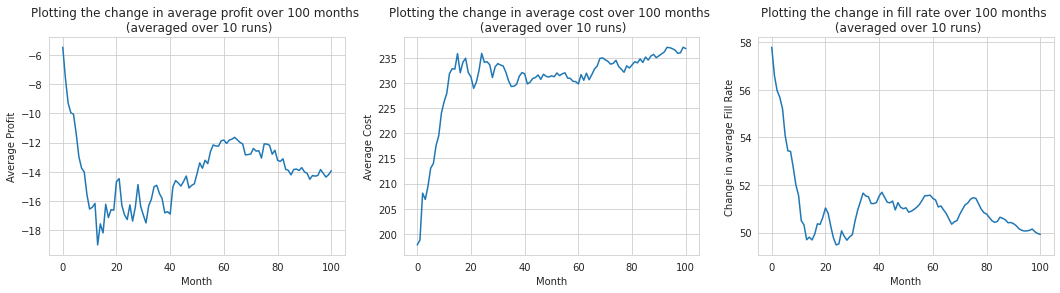


------------------------------------------------------------------------------------------------
RESULTS:
Parameters chosen: M = 50 | L = 30 | initial inventory = 50 | number of months simulated = 112 | runs = 10

Estimate of the Average monthly profit: -13.928171091445426
Estimate of the Average monthly cost: 236.8396755162242
90% Confidence interval for average monthly profit: [-17.007242479654508, -10.849099703236345]
90% Confidence interval for average monthly cost: [226.63955185278292, 247.03979917966547]
Average Fill Rate at the end of 100 months: 49.92228888318749
------------------------------------------------------------------------------------------------


In [ ]:
#############################################
## Defining the parameters of the model 
#############################################
num_months = 100
init_inventory = 50
M = 50
L = 30
runs = 10
warmup = 12
num_months += warmup

avg_profit, profit_conf_interval_halfwidth, avg_cost, sd_cost, cost_conf_interval_halfwidth, avg_fill_rate = algo_over_runs(runs, discrete, num_months, init_inventory, M, L, warmup)

print('\n------------------------------------------------------------------------------------------------')
print("\033[1mRESULTS:\033[0m")
print(f"Parameters chosen: M = {M} | L = {L} | initial inventory = {init_inventory} | number of months simulated = {num_months} | runs = {runs}\n")
print (f"Estimate of the Average monthly profit: {avg_profit}")
print (f"Estimate of the Average monthly cost: {avg_cost}")
print(f"90% Confidence interval for average monthly profit: [{avg_profit - profit_conf_interval_halfwidth}, {avg_profit + profit_conf_interval_halfwidth}]")
print(f"90% Confidence interval for average monthly cost: [{avg_cost - cost_conf_interval_halfwidth}, {avg_cost + cost_conf_interval_halfwidth}]")
print(f"Average Fill Rate at the end of {num_months - warmup} months: {avg_fill_rate}")
print('------------------------------------------------------------------------------------------------')

---
## **Question (b)** 

#### Using results of part(a), estimate the total number of replications needed to estimate mean monthly cost within $5. Run the model the required number of replications and construct the CI.
---


RESULT:
Optimal number of replications required to have halfwidth <= $5: 33
------------------------------------------------------------------------------------------------



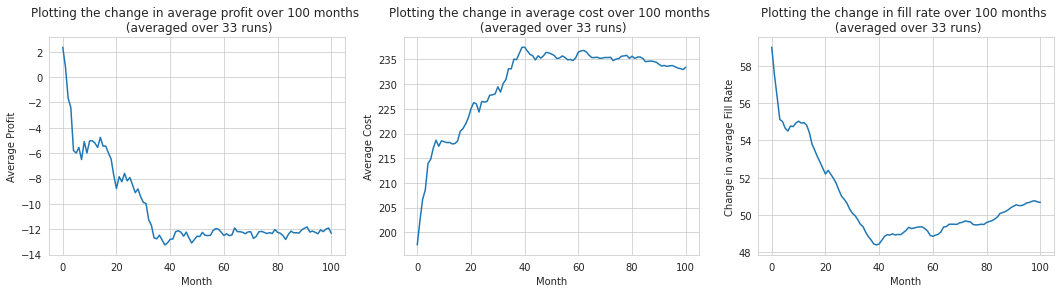


---------------------------------------------------------------------------------------------------------------------
RESULTS with the new number of replications:
Parameters chosen: M = 50 | L = 30 | initial inventory = 50 | number of months simulated = 112 | replications = 33

Estimate of the Average monthly profit: -12.32030034861893
Estimate of the Average monthly cost: 233.43051756503084
90% Confidence interval for average monthly profit: [-14.448765875930544, -10.191834821307317]
90% Confidence interval for average monthly cost: [228.71693755830864, 238.14409757175304]
----------------------------------------------------------------------------------------------------------------------


In [ ]:
###############################################################################
## Finding the number of replications to estimate mean monthly cost within $5
###############################################################################
R0 = runs
S0 = sd_cost
cost_range = 5
R = R0
alpha = 0.1

while ss.t.ppf(0.95, df = R-1)*(S0/np.sqrt(R)) > 5:
    R += 1
    
print("\n\033[1mRESULT:\033[0m")
print(f"Optimal number of replications required to have halfwidth <= $5: {R}")
print('------------------------------------------------------------------------------------------------\n')

#############################################
## Defining the parameters of the model 
#############################################
num_months = 100
init_inventory = 50
M = 50
L = 30
runs = R
warmup = 12
num_months += warmup

avg_profit, profit_conf_interval_halfwidth, avg_cost, sd_cost, cost_conf_interval_halfwidth, avg_fill_rate = algo_over_runs(runs, discrete, num_months, init_inventory, M, L, warmup)

print('\n---------------------------------------------------------------------------------------------------------------------')
print("\033[1mRESULTS with the new number of replications:\033[0m")
print(f"Parameters chosen: M = {M} | L = {L} | initial inventory = {init_inventory} | number of months simulated = {num_months} | replications = {runs}\n")
print (f"Estimate of the Average monthly profit: {avg_profit}")
print (f"Estimate of the Average monthly cost: {avg_cost}")
print(f"90% Confidence interval for average monthly profit: [{avg_profit - profit_conf_interval_halfwidth}, {avg_profit + profit_conf_interval_halfwidth}]")
print(f"90% Confidence interval for average monthly cost: [{avg_cost - cost_conf_interval_halfwidth}, {avg_cost + cost_conf_interval_halfwidth}]")
print('----------------------------------------------------------------------------------------------------------------------')

---
## **Addendum Option (C)**
#### Keep Factor2 at Level 1, and Factory 5 at Level 1. Compare the performances of systems across the design points of F1, F3 and F4 (total 8 combinations). Also, find the minimum mean monthly cost combination of M and L such that Fill Rate is $\geq 99$%.
---

In [11]:
#########################################################################################################################################################
## Main Function for the simulation. This function is for the inventory review strategy where inventory reviewed continuously
## Input params:  num_months: No. of months over which simulating  || init_inventory - initial inventory level || L - Re-order point || M: Max inventory 
#########################################################################################################################################################

def continuous_inventory_model(num_months, init_inventory, M, L, warmup):

    ordering_cost = 0                           ## Total ordering cost
    revenue = 0                                 ## Total revenue till time t
    holding_cost = 0                            ## Total inventory holding cost 
    time = 0                                    ## Time index
    inventory = [init_inventory]                ## Amount of inventory on hand
    order_qty = 0                               ## Amount on order
    customer_arrival_time = 0                   ## Arrival time of next customer
    order_delivery_time = np.infty              ## Delivery time of order. If no outstanding order, order_delivery_time = Infinity
    month = 0                                   ## month is a counter variable
    batch_time_on_shelf = [0]                   ## List to track the time on shelf of the inventory units
    profit_array = []                           ## Empty array for storing profits in each month
    cost_array = []                             ## Empty array for storing costs in each month
    fill_rate = []
    backorder = 0
    backorder_qty=[]
    backorder_time=[]
    backorder_cost=0
    fulfilled_demand = 0
    total_demand = 0
    while month <= num_months:
        customer_arrival_time = 0
        time = 0
        while time <= 1: 
            if customer_arrival_time < order_delivery_time: 
                holding_cost = holding_cost + calculate_holding_cost(inventory, batch_time_on_shelf)
                time = customer_arrival_time
                demand = generate_demand()       
                
                if demand <= sum(inventory):
                    rev, inventory, batch_time_on_shelf, _ = revenue_and_stock_update(inventory, batch_time_on_shelf, demand)
                    revenue += rev 
                    fulfilled_demand += demand
                    total_demand = total_demand + demand
                else:
                    backorder = demand - sum(inventory)
                    fulfilled_demand += sum(inventory)
                    total_demand += demand
                    rev, inventory, batch_time_on_shelf, _ = revenue_and_stock_update(inventory, batch_time_on_shelf, sum(inventory))
                    revenue += rev 
                    backorder_qty.append(backorder)
                    backorder_time.append(0)

                if sum(inventory) <= L and (order_qty == 0):
                    order_qty = M - sum(inventory)
                    order_delivery_time = time + np.random.uniform(low = 0.25, high = 1.25)

          
                customer_arrival_time = time + np.random.exponential(1/15)     
            else:
                holding_cost = holding_cost + calculate_holding_cost(inventory, batch_time_on_shelf)
                time = order_delivery_time
                ordering_cost = ordering_cost + continuous_cost_gen(order_qty)    ## Updating the total order cost
                bk_order_cost,backorder_qty,backorder_time,backorder_prev=backorder_update(backorder_qty,backorder_time,order_qty)
                
                revenue += 10*min(order_qty, backorder_prev)
                order_qty = max(0, order_qty - backorder_prev)
                backorder_cost+=bk_order_cost

                inventory.append(order_qty)                              ## New inventory level, with the new order appended
                batch_time_on_shelf.append(0)                            ## Appending batch time = 0 for the new items in inventory
                order_qty = 0                                            ## Amount on order. Zero since no outstanding order
                order_delivery_time = np.infty    
            
            # print(f"time: {time}, demand: {demand}, inventory: {inventory} batch time on shelf {batch_time_on_shelf} || order qty {order_qty}")    
            # print(f'back order time{backorder_time}, back order qty {backorder_qty}')
            # print(f'Cost: {backorder_cost}')
        
        ## Check the inventory status
        if month>=warmup:  
            avg_profit = (revenue - ordering_cost - holding_cost-backorder_cost) / (month+1)
            avg_cost = (ordering_cost + holding_cost+backorder_cost) / (month+1)
            fill_rate.append((fulfilled_demand / total_demand)*100)
            profit_array.append(avg_profit)
            cost_array.append(avg_cost)

        if sum(inventory) <= L and (order_qty > 0):
            order_delivery_time = order_delivery_time - 1
        month +=1
        backorder = 0
        batch_time_on_shelf = [batch_time_on_shelf[i]+1 for i in range(len(batch_time_on_shelf))]
        backorder_time= [backorder_time[i]+1 for i in range(len(backorder_time))]
        inventory = np.array(inventory)
        batch_time_on_shelf = np.array(batch_time_on_shelf)

        valid_idx = np.where((batch_time_on_shelf <= 2) & (inventory > 0))[0]
        inventory = inventory[valid_idx].tolist() 
        batch_time_on_shelf = batch_time_on_shelf[valid_idx].tolist()
        

    return profit_array, cost_array, fill_rate

### **Case 1:**
- Factor 1: Periodic review 
- Factor 2: Excess demand backordered
- Factor 3: M = 50
- Factor 4: L = 30
- Factor 5: Service level measure is fill Rate

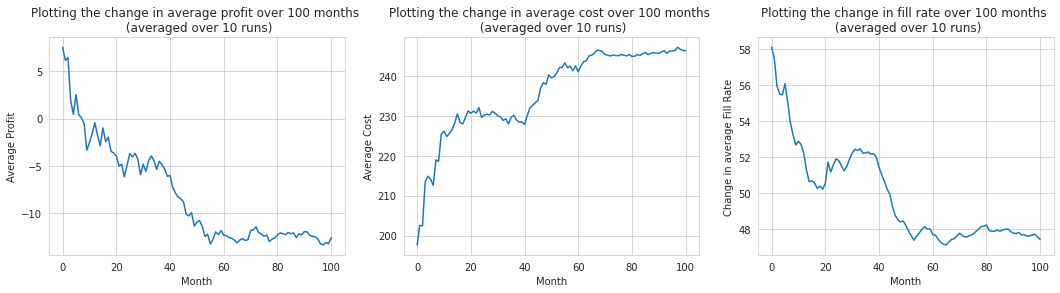


----------------------------------------------------------------------------------------------------------------------------------------------------
RESULTS:
Parameters chosen: M = 50 | L = 30 | initial inventory = 50 | number of months simulated = 112 | replications = 10 | Review policy = Monthly

Estimate of the Average monthly profit: -12.602507374631266
Estimate of the Average monthly cost: 246.30162241887905
90% Confidence interval for average monthly profit: [-17.323393410766776, -7.881621338495754]
90% Confidence interval for average monthly cost: [236.5463487437745, 256.0568960939836]
Average Fill Rate at the end of 100 months: 47.44530141359639
-------------------------------------------------------------------------------------------------------------------------------------------------------


In [12]:
num_months = 100
init_inventory = 50
M = 50
L = 30
runs = 10
warmup = 12
num_months += warmup
algo_type = discrete

avg_profit, profit_conf_interval_halfwidth, avg_cost, sd_cost, cost_conf_interval_halfwidth, avg_fill_rate = algo_over_runs(runs, algo_type, num_months, init_inventory, M, L, warmup)

print('\n----------------------------------------------------------------------------------------------------------------------------------------------------')
print("\033[1mRESULTS:\033[0m")
print(f"Parameters chosen: M = {M} | L = {L} | initial inventory = {init_inventory} | number of months simulated = {num_months} | replications = {runs} | Review policy = Monthly\n")
print (f"Estimate of the Average monthly profit: {avg_profit}")
print (f"Estimate of the Average monthly cost: {avg_cost}")
print(f"90% Confidence interval for average monthly profit: [{avg_profit - profit_conf_interval_halfwidth}, {avg_profit + profit_conf_interval_halfwidth}]")
print(f"90% Confidence interval for average monthly cost: [{avg_cost - cost_conf_interval_halfwidth}, {avg_cost + cost_conf_interval_halfwidth}]")
print(f"Average Fill Rate at the end of {num_months - warmup} months: {avg_fill_rate}")
print('-------------------------------------------------------------------------------------------------------------------------------------------------------')

### **Case 2:**
- Factor 1: Periodic review 
- Factor 2: Excess demand backordered
- Factor 3: M = 50
- Factor 4: L = 40
- Factor 5: Service level measure is fill Rate

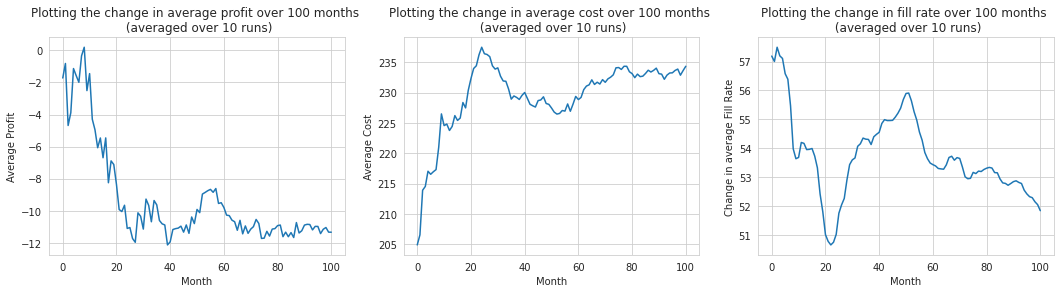


-----------------------------------------------------------------------------------------------------------------------------------------------------
RESULTS:
Parameters chosen: M = 50 | L = 40 | initial inventory = 50 | number of months simulated = 112 | replications = 10 | Review policy = Monthly

Estimate of the Average monthly profit: -11.342448377581118
Estimate of the Average monthly cost: 234.3291740412979
90% Confidence interval for average monthly profit: [-14.981386313031656, -7.703510442130579]
90% Confidence interval for average monthly cost: [224.88909656201469, 243.76925152058112]
Average Fill Rate at the end of 100 months: 51.839360684634606
--------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
num_months = 100
init_inventory = 50
M = 50
L = 40
runs = 10
warmup = 12
num_months += warmup
algo_type = discrete

avg_profit, profit_conf_interval_halfwidth, avg_cost, sd_cost, cost_conf_interval_halfwidth, avg_fill_rate = algo_over_runs(runs, algo_type, num_months, init_inventory, M, L, warmup)

print('\n-----------------------------------------------------------------------------------------------------------------------------------------------------')
print("\033[1mRESULTS:\033[0m")
print(f"Parameters chosen: M = {M} | L = {L} | initial inventory = {init_inventory} | number of months simulated = {num_months} | replications = {runs} | Review policy = Monthly\n")
print (f"Estimate of the Average monthly profit: {avg_profit}")
print (f"Estimate of the Average monthly cost: {avg_cost}")
print(f"90% Confidence interval for average monthly profit: [{avg_profit - profit_conf_interval_halfwidth}, {avg_profit + profit_conf_interval_halfwidth}]")
print(f"90% Confidence interval for average monthly cost: [{avg_cost - cost_conf_interval_halfwidth}, {avg_cost + cost_conf_interval_halfwidth}]")
print(f"Average Fill Rate at the end of {num_months - warmup} months: {avg_fill_rate}")
print('--------------------------------------------------------------------------------------------------------------------------------------------------------')

### **Case 3:**
- Factor 1: Periodic review 
- Factor 2: Excess demand backordered
- Factor 3: M = 100
- Factor 4: L = 30
- Factor 5: Service level measure is fill Rate

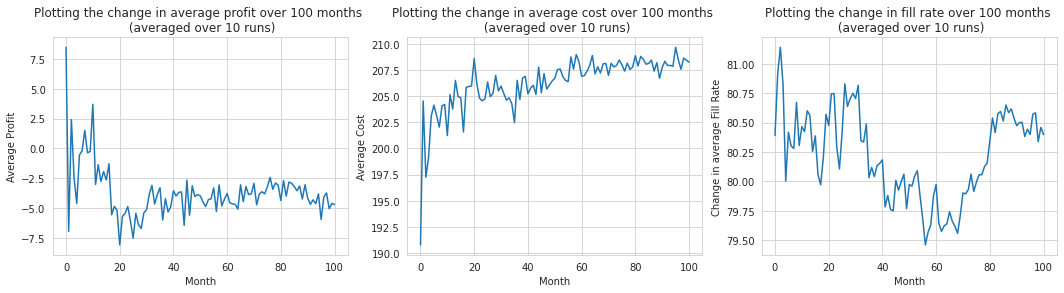


----------------------------------------------------------------------------------------------------------------------------------------------------
RESULTS:
Parameters chosen: M = 100 | L = 30 | initial inventory = 50 | number of months simulated = 112 | replications = 10 | Review policy = Monthly

Estimate of the Average monthly profit: -4.704129793510325
Estimate of the Average monthly cost: 208.2395280235988
90% Confidence interval for average monthly profit: [-7.2303098460565, -2.177949740964151]
90% Confidence interval for average monthly cost: [204.76231146827735, 211.71674457892027]
Average Fill Rate at the end of 100 months: 80.39821426193106
-------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
num_months = 100
init_inventory = 50
M = 100
L = 30
runs = 10
warmup = 12
num_months += warmup
algo_type = discrete

avg_profit, profit_conf_interval_halfwidth, avg_cost, sd_cost, cost_conf_interval_halfwidth, avg_fill_rate = algo_over_runs(runs, algo_type, num_months, init_inventory, M, L, warmup)

print('\n----------------------------------------------------------------------------------------------------------------------------------------------------')
print("\033[1mRESULTS:\033[0m")
print(f"Parameters chosen: M = {M} | L = {L} | initial inventory = {init_inventory} | number of months simulated = {num_months} | replications = {runs} | Review policy = Monthly\n")
print (f"Estimate of the Average monthly profit: {avg_profit}")
print (f"Estimate of the Average monthly cost: {avg_cost}")
print(f"90% Confidence interval for average monthly profit: [{avg_profit - profit_conf_interval_halfwidth}, {avg_profit + profit_conf_interval_halfwidth}]")
print(f"90% Confidence interval for average monthly cost: [{avg_cost - cost_conf_interval_halfwidth}, {avg_cost + cost_conf_interval_halfwidth}]")
print(f"Average Fill Rate at the end of {num_months - warmup} months: {avg_fill_rate}")
print('-------------------------------------------------------------------------------------------------------------------------------------------------------')

### **Case 4:**
- Factor 1: Periodic review 
- Factor 2: Excess demand backordered
- Factor 3: M = 100
- Factor 4: L = 40
- Factor 5: Service level measure is fill Rate

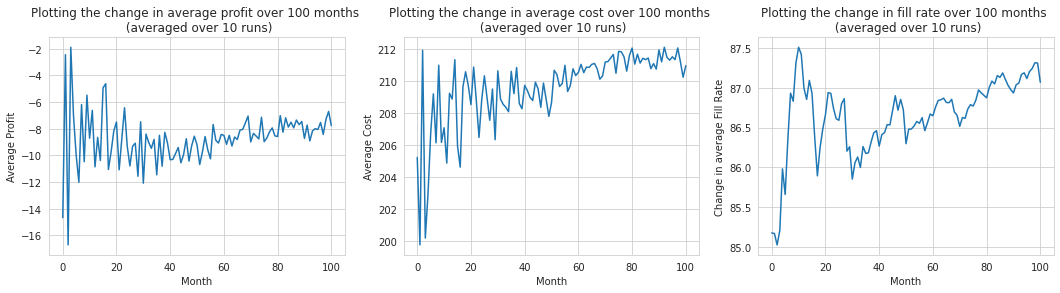


-----------------------------------------------------------------------------------------------------------------------------------------------------
RESULTS:
Parameters chosen: M = 100 | L = 40 | initial inventory = 50 | number of months simulated = 112 | replications = 10 | Review policy = Monthly

Estimate of the Average monthly profit: -7.757522123893812
Estimate of the Average monthly cost: 210.983185840708
90% Confidence interval for average monthly profit: [-9.73918361238117, -5.775860635406454]
90% Confidence interval for average monthly cost: [207.13519292971262, 214.83117875170336]
Average Fill Rate at the end of 100 months: 87.06906555594144
--------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
num_months = 100
init_inventory = 50
M = 100
L = 40
runs = 10
warmup = 12
num_months += warmup
algo_type = discrete

avg_profit, profit_conf_interval_halfwidth, avg_cost, sd_cost, cost_conf_interval_halfwidth, avg_fill_rate = algo_over_runs(runs, algo_type, num_months, init_inventory, M, L, warmup)

print('\n-----------------------------------------------------------------------------------------------------------------------------------------------------')
print("\033[1mRESULTS:\033[0m")
print(f"Parameters chosen: M = {M} | L = {L} | initial inventory = {init_inventory} | number of months simulated = {num_months} | replications = {runs} | Review policy = Monthly\n")
print (f"Estimate of the Average monthly profit: {avg_profit}")
print (f"Estimate of the Average monthly cost: {avg_cost}")
print(f"90% Confidence interval for average monthly profit: [{avg_profit - profit_conf_interval_halfwidth}, {avg_profit + profit_conf_interval_halfwidth}]")
print(f"90% Confidence interval for average monthly cost: [{avg_cost - cost_conf_interval_halfwidth}, {avg_cost + cost_conf_interval_halfwidth}]")
print(f"Average Fill Rate at the end of {num_months - warmup} months: {avg_fill_rate}")
print('--------------------------------------------------------------------------------------------------------------------------------------------------------')

### **Case 5:**
- Factor 1: Continuous review 
- Factor 2: Excess demand backordered
- Factor 3: M = 50
- Factor 4: L = 30
- Factor 5: Service level measure is fill Rate

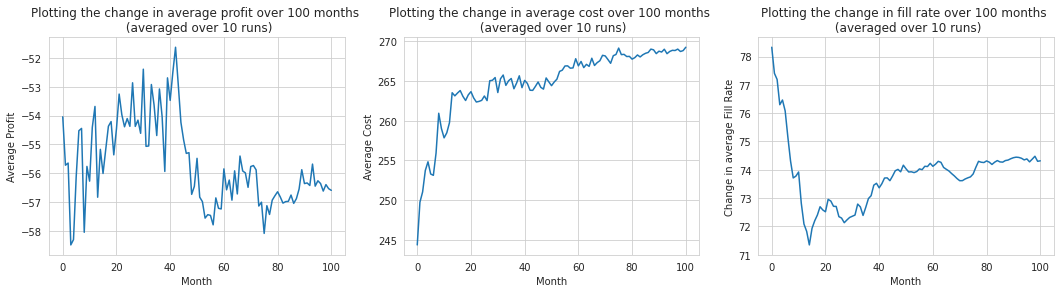


-----------------------------------------------------------------------------------------------------------------------------------------------------
RESULTS:
Parameters chosen: M = 50 | L = 30 | initial inventory = 50 | number of months simulated = 112 | replications = 10 | Review policy = Continuous

Estimate of the Average monthly profit: -56.594985250737466
Estimate of the Average monthly cost: 269.2233038348083
90% Confidence interval for average monthly profit: [-61.78774319771913, -51.4022273037558]
90% Confidence interval for average monthly cost: [265.57693459878715, 272.86967307082944]
Average Fill Rate at the end of 100 months: 74.3168489303911
-------------------------------------------------------------------------------------------------------------------------------------------------------


In [35]:
num_months = 100
init_inventory = 50
M = 50
L = 30
runs = 10
warmup = 12
num_months += warmup
algo_type = continuous

avg_profit, profit_conf_interval_halfwidth, avg_cost, sd_cost, cost_conf_interval_halfwidth, avg_fill_rate = algo_over_runs(runs, algo_type, num_months, init_inventory, M, L, warmup, plot = True)

print('\n-----------------------------------------------------------------------------------------------------------------------------------------------------')
print("\033[1mRESULTS:\033[0m")
print(f"Parameters chosen: M = {M} | L = {L} | initial inventory = {init_inventory} | number of months simulated = {num_months} | replications = {runs} | Review policy = Continuous\n")
print (f"Estimate of the Average monthly profit: {avg_profit}")
print (f"Estimate of the Average monthly cost: {avg_cost}")
print(f"90% Confidence interval for average monthly profit: [{avg_profit - profit_conf_interval_halfwidth}, {avg_profit + profit_conf_interval_halfwidth}]")
print(f"90% Confidence interval for average monthly cost: [{avg_cost - cost_conf_interval_halfwidth}, {avg_cost + cost_conf_interval_halfwidth}]")
print(f"Average Fill Rate at the end of {num_months - warmup} months: {avg_fill_rate}")
print('-------------------------------------------------------------------------------------------------------------------------------------------------------')

### **Case 6:**
- Factor 1: Continuous review 
- Factor 2: Excess demand backordered
- Factor 3: M = 50
- Factor 4: L = 40
- Factor 5: Service level measure is fill Rate

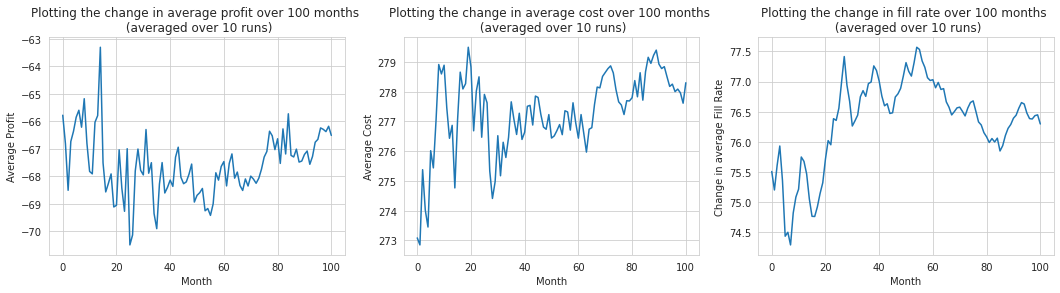


------------------------------------------------------------------------------------------------------------------------------------------------------
RESULTS:
Parameters chosen: M = 50 | L = 40 | initial inventory = 50 | number of months simulated = 112 | replications = 10 | Review policy = Continuous

Estimate of the Average monthly profit: -66.51162241887907
Estimate of the Average monthly cost: 278.29923303834806
90% Confidence interval for average monthly profit: [-69.7168269185505, -63.306417919207654]
90% Confidence interval for average monthly cost: [274.4277049874309, 282.1707610892652]
Average Fill Rate at the end of 100 months: 76.29631182267265
--------------------------------------------------------------------------------------------------------------------------------------------------------


In [27]:
num_months = 100
init_inventory = 50
M = 50
L = 40
runs = 10
warmup = 12
num_months += warmup
algo_type = continuous

avg_profit, profit_conf_interval_halfwidth, avg_cost, sd_cost, cost_conf_interval_halfwidth, avg_fill_rate = algo_over_runs(runs, algo_type, num_months, init_inventory, M, L, warmup)

print('\n------------------------------------------------------------------------------------------------------------------------------------------------------')
print("\033[1mRESULTS:\033[0m")
print(f"Parameters chosen: M = {M} | L = {L} | initial inventory = {init_inventory} | number of months simulated = {num_months} | replications = {runs} | Review policy = Continuous\n")
print (f"Estimate of the Average monthly profit: {avg_profit}")
print (f"Estimate of the Average monthly cost: {avg_cost}")
print(f"90% Confidence interval for average monthly profit: [{avg_profit - profit_conf_interval_halfwidth}, {avg_profit + profit_conf_interval_halfwidth}]")
print(f"90% Confidence interval for average monthly cost: [{avg_cost - cost_conf_interval_halfwidth}, {avg_cost + cost_conf_interval_halfwidth}]")
print(f"Average Fill Rate at the end of {num_months - warmup} months: {avg_fill_rate}")
print('--------------------------------------------------------------------------------------------------------------------------------------------------------')

### **Case 7:**
- Factor 1: Continuous review 
- Factor 2: Excess demand backordered
- Factor 3: M = 100
- Factor 4: L = 30
- Factor 5: Service level measure is fill Rate

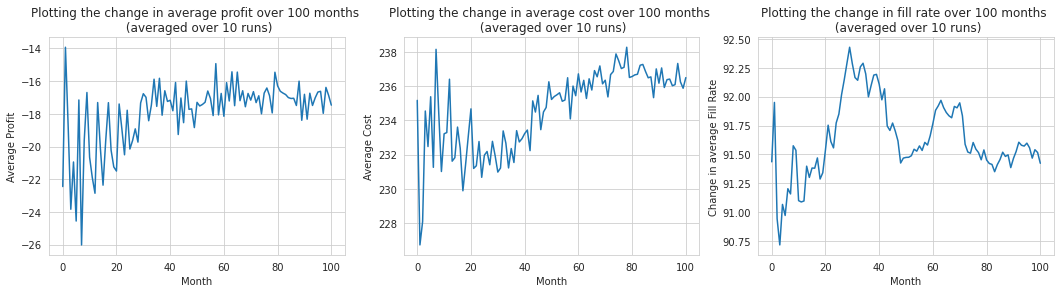


------------------------------------------------------------------------------------------------------------------------------------------------------
RESULTS:
Parameters chosen: M = 100 | L = 30 | initial inventory = 50 | number of months simulated = 112 | replications = 10 | Review policy = Continuous

Estimate of the Average monthly profit: -17.465545722713866
Estimate of the Average monthly cost: 236.50979351032447
90% Confidence interval for average monthly profit: [-21.296133179011175, -13.634958266416557]
90% Confidence interval for average monthly cost: [233.0751124520657, 239.94447456858325]
Average Fill Rate at the end of 100 months: 91.42317184441741
--------------------------------------------------------------------------------------------------------------------------------------------------------


In [28]:
num_months = 100
init_inventory = 50
M = 100
L = 30
runs = 10
warmup = 12
num_months += warmup
algo_type = continuous

avg_profit, profit_conf_interval_halfwidth, avg_cost, sd_cost, cost_conf_interval_halfwidth, avg_fill_rate = algo_over_runs(runs, algo_type, num_months, init_inventory, M, L, warmup)

print('\n------------------------------------------------------------------------------------------------------------------------------------------------------')
print("\033[1mRESULTS:\033[0m")
print(f"Parameters chosen: M = {M} | L = {L} | initial inventory = {init_inventory} | number of months simulated = {num_months} | replications = {runs} | Review policy = Continuous\n")
print (f"Estimate of the Average monthly profit: {avg_profit}")
print (f"Estimate of the Average monthly cost: {avg_cost}")
print(f"90% Confidence interval for average monthly profit: [{avg_profit - profit_conf_interval_halfwidth}, {avg_profit + profit_conf_interval_halfwidth}]")
print(f"90% Confidence interval for average monthly cost: [{avg_cost - cost_conf_interval_halfwidth}, {avg_cost + cost_conf_interval_halfwidth}]")
print(f"Average Fill Rate at the end of {num_months - warmup} months: {avg_fill_rate}")
print('--------------------------------------------------------------------------------------------------------------------------------------------------------')

### **Case 8:**
- Factor 1: Continuous review 
- Factor 2: Excess demand backordered
- Factor 3: M = 100
- Factor 4: L = 40
- Factor 5: Service level measure is fill Rate

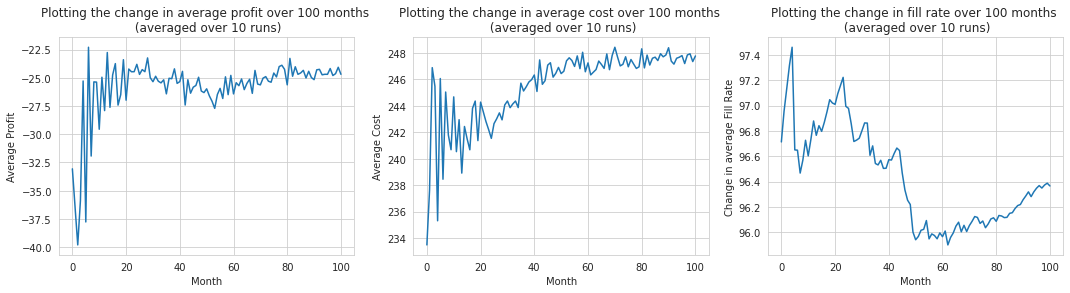


---------------------------------------------------------------------------------------------------------------------------------------------------
RESULTS:
Parameters chosen: M = 100 | L = 40 | initial inventory = 50 | number of months simulated = 112 | replications = 10 | Review policy = Continuous

Estimate of the Average monthly profit: -24.689292035398243
Estimate of the Average monthly cost: 247.75566371681415
90% Confidence interval for average monthly profit: [-28.226210552773722, -21.152373518022763]
90% Confidence interval for average monthly cost: [244.4322674502715, 251.0790599833568]
Average Fill Rate at the end of 100 months: 96.36581130230209
----------------------------------------------------------------------------------------------------------------------------------------------------


In [29]:
num_months = 100
init_inventory = 50
M = 100
L = 40
runs = 10
warmup = 12
num_months += warmup
algo_type = continuous

avg_profit, profit_conf_interval_halfwidth, avg_cost, sd_cost, cost_conf_interval_halfwidth, avg_fill_rate = algo_over_runs(runs, algo_type, num_months, init_inventory, M, L, warmup)

print('\n---------------------------------------------------------------------------------------------------------------------------------------------------')
print("\033[1mRESULTS:\033[0m")
print(f"Parameters chosen: M = {M} | L = {L} | initial inventory = {init_inventory} | number of months simulated = {num_months} | replications = {runs} | Review policy = Continuous\n")
print (f"Estimate of the Average monthly profit: {avg_profit}")
print (f"Estimate of the Average monthly cost: {avg_cost}")
print(f"90% Confidence interval for average monthly profit: [{avg_profit - profit_conf_interval_halfwidth}, {avg_profit + profit_conf_interval_halfwidth}]")
print(f"90% Confidence interval for average monthly cost: [{avg_cost - cost_conf_interval_halfwidth}, {avg_cost + cost_conf_interval_halfwidth}]")
print(f"Average Fill Rate at the end of {num_months - warmup} months: {avg_fill_rate}")
print('----------------------------------------------------------------------------------------------------------------------------------------------------')

### **Finding best M, L pair such that cost is minimum and fill rate $\geq 99$%:**

In [325]:
def optimal_M_L(max_M, min_M, max_L, min_L, runs, algo_type, num_months, init_inventory, M, L, warmup, plot):
    min_cost = np.infty
    best_pair = [0, 0]
    for M in range(min_M, max_M, 1):
        for L in range(min_L, max_L, 1):
            if L < M:
                _, _, avg_cost, _, _, avg_fill_rate = algo_over_runs(runs, algo_type, num_months, init_inventory, M, L, warmup, plot)
                if avg_fill_rate >= 99:
                    if avg_cost < min_cost:
                        best_pair = [M, L]
                        min_cost = avg_cost
        print(f"Done for M = {M} and all L, current best pair: {best_pair}, current min cost: {min_cost}")
    return best_pair            

In [326]:
algo_type = continuous
init_inventory = 50
runs = 10
num_months = 100
warmup = 12
num_months += warmup
max_M, min_M = 150, 50
max_L, min_L = 140, 30

best_pair = optimal_M_L(max_M, min_M, max_L, min_L, runs, algo_type, num_months, init_inventory, M, L, warmup, plot = False)

Done for M = 50 and all L, current best pair: [0, 0], current min cost: inf
Done for M = 51 and all L, current best pair: [0, 0], current min cost: inf
Done for M = 52 and all L, current best pair: [0, 0], current min cost: inf
Done for M = 53 and all L, current best pair: [0, 0], current min cost: inf
Done for M = 54 and all L, current best pair: [0, 0], current min cost: inf
Done for M = 55 and all L, current best pair: [0, 0], current min cost: inf
Done for M = 56 and all L, current best pair: [0, 0], current min cost: inf
Done for M = 57 and all L, current best pair: [0, 0], current min cost: inf
Done for M = 58 and all L, current best pair: [0, 0], current min cost: inf
Done for M = 59 and all L, current best pair: [0, 0], current min cost: inf
Done for M = 60 and all L, current best pair: [0, 0], current min cost: inf
Done for M = 61 and all L, current best pair: [0, 0], current min cost: inf
Done for M = 62 and all L, current best pair: [0, 0], current min cost: inf
Done for M =